In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skimage.color import rgb2gray
from sklearn.preprocessing import normalize

In [2]:
# Görüntüyü işleme ve özellik çıkarma fonksiyonları
def preprocess_image(image):
    blurred_image = cv2.medianBlur(image, ksize=5)
    blurred_image = cv2.resize(blurred_image, (64, 64))
    return blurred_image

In [3]:
def extract_hog_features(image):
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    h = hog.compute(image)
    return h.flatten()

In [4]:
def calculate_geometric_features(landmarks):
    features = []
    if landmarks is not None:
        # Gözler arası mesafe
        eye_distance = np.linalg.norm(landmarks[36] - landmarks[45])
        features.append(eye_distance)
        # Burun uzunluğu
        nose_length = np.linalg.norm(landmarks[27] - landmarks[33])
        features.append(nose_length)
        # Ağız genişliği
        mouth_width = np.linalg.norm(landmarks[48] - landmarks[54])
        features.append(mouth_width)
        # Diğer özellikler...
    return features

In [5]:
def extract_lbp_features(image, P=8, R=1):
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P, R, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

In [1]:
# Veri okuma ve bölme

def read_and_split_data(directory_path, test_size=0.2):
    faceImgList = []
    hog_featuresList = []
    labels = []
    label_names = []

    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    for root, dirs, files in os.walk(directory_path):
        for dir in dirs:
            current_dir_path = os.path.join(root, dir)
            image_files = [f for f in os.listdir(current_dir_path) if f.endswith(".jpg") or f.endswith(".png")]
            
            for file in image_files:
                image_path = os.path.join(current_dir_path, file)
                image = cv2.imread(image_path)
                
                if image is not None:
                    faces = face_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)
                    for (x, y, w, h) in faces:
                        face_img = image[y:y+h, x:x+w]
                    
                        face_img = preprocess_image(face_img)
                        hog_features = extract_hog_features(face_img)
                        faceImgList.append(face_img)
                        hog_featuresList.append(hog_features)
                        labels.append(dir)
            
            if dir not in label_names:
                label_names.append(dir)

    X_train, X_test, y_train, y_test = train_test_split(hog_featuresList, labels, test_size=test_size, stratify=labels)
    return X_train, X_test, y_train, y_test


ModuleNotFoundError: No module named 'dlib'

In [7]:
# Öklid Mesafesi Fonksiyonu
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)


In [8]:
def manhattan_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))

In [9]:
def minkowski_distance(vec1, vec2, p):
    return np.sum(np.abs(vec1 - vec2)**p)**(1/p)

In [10]:
from scipy.spatial import distance
def cosine_similarity(vec1, vec2):
    return 1 - distance.cosine(vec1, vec2)

In [11]:
def jaccard_similarity(vec1, vec2):
    intersection = np.sum(np.minimum(vec1, vec2))
    union = np.sum(np.maximum(vec1, vec2))
    return intersection / union

In [12]:
def hamming_distance(vec1, vec2):
    return np.sum(vec1 != vec2) / len(vec1)

In [13]:

# En Yakın Yüzü Bulma Fonksiyonu
def find_closest_face(test_feature, database_features):
    min_distance = float('inf')
    closest_face = None

    for db_feature, db_label in database_features:
        distance = euclidean_distance(test_feature, db_feature)
        if distance < min_distance:
            min_distance = distance
            closest_face = db_label

    return closest_face

In [74]:
# Ana Akış
X_train, X_test, y_train, y_test = read_and_split_data("105_classes_pins_dataset")


In [75]:
def save_image(image, label, is_correct, correct_directory="Yontem_1\True", incorrect_directory="Yontem_1\False"):
    # Doğru ya da yanlış sınıflandırılmış örnekleri kaydetmek için dizinleri kontrol et
    if not os.path.exists(correct_directory):
        os.makedirs(correct_directory)
    if not os.path.exists(incorrect_directory):
        os.makedirs(incorrect_directory)
    
    # Resmi kaydet
    filename = f"{label}.png"  # Burada, dosya adı olarak sadece label kullanılmıştır, çakışmaları önlemek için daha karmaşık bir yöntem kullanabilirsiniz.
    path = os.path.join(correct_directory if is_correct else incorrect_directory, filename)
    image.save(path)

In [76]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
def predict_and_visualize(image_path, X_train, y_train, distance_metric):

    lda = LDA()
    lda.fit(X_train, y_train)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    image = cv2.imread(image_path)
                
    if image is not None:
        faces = face_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)
        for (x, y, w, h) in faces:
            face_img = image[y:y+h, x:x+w] 
            face_img = preprocess_image(face_img)
            hog_features = extract_hog_features(face_img)
        if len(faces) <1:
            face_img = preprocess_image(image)
            hog_features = extract_hog_features(face_img)
  


    X_train_lda = lda.transform(X_train)
    
    hog_features_lda = lda.transform(np.array([hog_features]))  

    # En yakın komşuyu bul
    min_distance = float('inf')
    predicted_label = None
    for train_feature, train_label in zip(X_train_lda, y_train):
        distance = distance_metric(hog_features_lda, train_feature)
        if distance < min_distance:
            min_distance = distance
            predicted_label = train_label
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resmi ve tahmini etiketi göster
    plt.imshow(image_rgb)
    plt.title(f"Predicted Label: {predicted_label}", fontsize=20, color='red')
    plt.axis('off')  # Eksenleri gizle
    plt.show()

    # return predicted_label

In [85]:
from PIL import Image
def calculate_accuracy_general(X_train, y_train, X_test, y_test, distance_metric):


    lda = LDA()
    # LDA modelini eğitim verileri üzerinde eğit
    lda.fit(X_train, y_train)

    # Eğitim ve test veri setlerini LDA ile dönüştür
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)

    X_train= X_train_lda

    X_test = X_test_lda

    train_data = list(zip(X_train, y_train))

    correct_predictions = 0
    total_predictions = len(X_test)

    # Sınıf başına doğru pozitif, yanlış pozitif, ve yanlış negatif sayıları
    true_positives = dict()
    false_positives = dict()
    false_negatives = dict()

    correctly_classified_samples = []
    incorrectly_classified_samples = []

    for i,(test_feature, true_label) in enumerate(zip(X_test, y_test)):
        closest_face = None
        min_distance = float('inf')

        for train_feature, train_label in train_data:
            distance = distance_metric(test_feature, train_feature)
            
            if distance < min_distance:
                min_distance = distance
                closest_face = train_label

        # Tahmin doğruysa
        if closest_face == true_label:
            correct_predictions += 1
            true_positives[true_label] = true_positives.get(true_label, 0) + 1
            # if i < 10:
            #     save_image(Image.fromarray(X_test_Images[i]), true_label, is_correct=True)
        else:
            false_positives[closest_face] = false_positives.get(closest_face, 0) + 1
            false_negatives[true_label] = false_negatives.get(true_label, 0) + 1
            # if i < 10:
            #     save_image(Image.fromarray(X_test_Images[i]), true_label, is_correct=False)

    # Her bir sınıf için F1 skorunu hesapla ve ortalama al
    f1_scores = []
    for label in set(y_train):
        tp = true_positives.get(label, 0)
        fp = false_positives.get(label, 0)
        fn = false_negatives.get(label, 0)
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)

    # Ortalama F1 skoru
    average_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    accuracy = correct_predictions / total_predictions
    return accuracy, average_f1_score

In [78]:
def calculate_accuracy_general_withoutLDA(X_train, y_train, X_test, y_test, distance_metric):

    train_data = list(zip(X_train, y_train))

    correct_predictions = 0
    total_predictions = len(X_test)

    # Sınıf başına doğru pozitif, yanlış pozitif, ve yanlış negatif sayıları
    true_positives = dict()
    false_positives = dict()
    false_negatives = dict()

    for test_feature, true_label in zip(X_test, y_test):
        closest_face = None
        min_distance = float('inf')

        for train_feature, train_label in train_data:
            distance = distance_metric(test_feature, train_feature)
            
            if distance < min_distance:
                min_distance = distance
                closest_face = train_label

        # Tahmin doğruysa
        if closest_face == true_label:
            correct_predictions += 1
            true_positives[true_label] = true_positives.get(true_label, 0) + 1
        else:
            false_positives[closest_face] = false_positives.get(closest_face, 0) + 1
            false_negatives[true_label] = false_negatives.get(true_label, 0) + 1

    # Her bir sınıf için F1 skorunu hesapla ve ortalama al
    f1_scores = []
    for label in set(y_train):
        tp = true_positives.get(label, 0)
        fp = false_positives.get(label, 0)
        fn = false_negatives.get(label, 0)
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)

    # Ortalama F1 skoru
    average_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    accuracy = correct_predictions / total_predictions
    return accuracy, average_f1_score

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np

def calculate_accuracy(X_train, y_train, X_test, y_test):
    lda = LDA(n_components=min(len(np.unique(y_train))-1, len(X_train[0])))
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(X_train_lda, y_train)
    y_pred = knn.predict(X_test_lda)
    accuracy = accuracy_score(y_test, y_pred)

    
    # F1 skorunu hesapla
    f1 = f1_score(y_test, y_pred, average='weighted')  

    return accuracy, f1

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def calculate_accuracy_with_svm(X_train, y_train, X_test, y_test):
    # LDA nesnesini başlat ve n_components ayarla
    lda = LDA(n_components=min(len(np.unique(y_train))-1, len(X_train[0])))
    
    # Eğitim verisi üzerinde LDA'yı fit edin ve dönüştürme uygulayın
    X_train_lda = lda.fit_transform(X_train, y_train)
    
    # Test verisini LDA ile dönüştürün
    X_test_lda = lda.transform(X_test)
    
    # SVM sınıflandırıcısını başlat
    best_svm = SVC(C=1000.0, class_weight='balanced', gamma=0.01)
    best_svm.fit(X_train_lda, y_train)

    # Make predictions with the best SVM
    y_pred_svm = best_svm.predict(X_test_lda)

    # Calculate and return the accuracy for SVM
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    
    
    # F1 skorunu hesapla
    f1 = f1_score(y_test, y_pred_svm, average='weighted')  
    return accuracy_svm,f1

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
def calculate_accuracy_with_pca(X_train, y_train, X_test, y_test):
    # PCA nesnesini başlatın. n_components, azaltılmış özellik uzayının boyutunu belirler.
    # Örneğin, veri setinizin varyansının büyük bir kısmını korumak için 0.95 gibi bir değer kullanabilirsiniz.
    lda = LDA(n_components=min(len(np.unique(y_train))-1, len(X_train[1])))
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    X_train = np.array(X_train_lda)
    X_test = np.array(X_test_lda)
    #pca = PCA(n_components=105)
    
    pca = PCA(n_components=104, svd_solver='randomized', whiten=True).fit(X_train)
    # Eğitim verisi üzerinde PCA'yı fit edin ve dönüşümü uygulayın
    X_train_pca = pca.fit_transform(X_train)

    # Test verisini dönüştürün
    X_test_pca = pca.transform(X_test)


    best_svm = SVC(C=1000.0, class_weight='balanced', gamma=0.01)
    best_svm.fit(X_train_pca, y_train)

    # Make predictions with the best SVM
    y_pred_svm = best_svm.predict(X_test_pca)

    # Calculate and return the accuracy for SVM
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    
    # F1 skorunu hesapla
    f1 = f1_score(y_test, y_pred_svm, average='weighted')  
    return  accuracy_svm,f1

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def calculate_accuracy_with_rf(X_train, y_train, X_test, y_test):
    # LDA ile boyut indirgeme
    lda = LDA(n_components=min(len(np.unique(y_train))-1, len(X_train[0])))
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Random Forest sınıflandırıcısını başlat
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators, ormanınızdaki ağaç sayısıdır

    # Eğitim verisi üzerinde Random Forest'ı eğit
    rf.fit(X_train_lda, y_train)

    # Test verisi üzerinde tahmin yap
    y_pred = rf.predict(X_test_lda)

    # Doğruluk oranını hesapla
    accuracy = accuracy_score(y_test, y_pred)
    
    # F1 skorunu hesapla
    f1 = f1_score(y_test, y_pred, average='weighted')  
    return accuracy,f1

In [86]:
# Öklid Mesafesi ile doğruluk hesapla
euclidean_accuracy, f1 = calculate_accuracy_general(X_train, y_train, X_test, y_test, euclidean_distance)
print("Euclidean Distance Accuracy:", euclidean_accuracy, " F1 Scorre: ", f1)

# Manhattan Mesafesi için doğruluk hesapla
manhattan_accuracy, f1  = calculate_accuracy_general(X_train, y_train, X_test, y_test, manhattan_distance)
print("Manhattan Distance Accuracy:", manhattan_accuracy, " F1 Scorre: ", f1)

# Minkowski Mesafesi için doğruluk hesapla
minkowski_accuracy, f1 = calculate_accuracy_general(X_train, y_train, X_test, y_test, lambda a, b: minkowski_distance(a, b, p=3))  # p değeri örnek olarak 3 alınmıştır
print("Minkowski Distance Accuracy:", minkowski_accuracy, " F1 Scorre: ", f1)

Euclidean Distance Accuracy: 0.44045728802794537  F1 Scorre:  0.45284879687888896
Manhattan Distance Accuracy: 0.4201333756748174  F1 Scorre:  0.4310890841654135


KeyboardInterrupt: 

In [87]:
# Öklid Mesafesi ile doğruluk hesapla
euclidean_accuracy, f1 = calculate_accuracy_general_withoutLDA(X_train, y_train, X_test, y_test, euclidean_distance)
print("Euclidean Distance without LDA Accuracy:", euclidean_accuracy, " F1 Scorre: ", f1)

# Manhattan Mesafesi için doğruluk hesapla
manhattan_accuracy, f1  = calculate_accuracy_general_withoutLDA(X_train, y_train, X_test, y_test, manhattan_distance)
print("Manhattan Distance without LDA Accuracy:", manhattan_accuracy, " F1 Scorre: ", f1)

# Minkowski Mesafesi için doğruluk hesapla
minkowski_accuracy, f1 = calculate_accuracy_general_withoutLDA(X_train, y_train, X_test, y_test, lambda a, b: minkowski_distance(a, b, p=3))  # p değeri örnek olarak 3 alınmıştır
print("Minkowski Distance without LDA Accuracy:", minkowski_accuracy, " F1 Scorre: ", f1)

Euclidean Distance without LDA Accuracy: 0.3906001905366783  F1 Scorre:  0.40030760833997714


KeyboardInterrupt: 

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracy, f1 = calculate_accuracy(X_train, y_train, X_test, y_test)
print("HOG + LDA + KNN Accuracy:", accuracy, " F1 Scorre: ", f1)

# Sadece SVM için doğruluk hesapla
accuracy_svm_only, f1 = calculate_accuracy_with_svm(X_train, y_train, X_test, y_test)
print("HOG + LDA + SVM Accuracy:", accuracy_svm_only, " F1 Scorre: ", f1)

# PCA ve KNN için doğruluk hesapla
accuracy_pca_svm , f1 = calculate_accuracy_with_pca(X_train, y_train, X_test, y_test)
print( "HOG + LDA + PCA + SVM Accuracy:", accuracy_pca_svm," F1 Scorre: ", f1)

# Random Forest için doğruluk hesapla
accuracy_rf , f1 = calculate_accuracy_with_rf(X_train, y_train, X_test, y_test)
print("HOG + LDA + Random Forest Accuracy:", accuracy_rf, " F1 Scorre: ", f1)


HOG + LDA + KNN Accuracy: 0.5023817084788822  F1 Scorre:  0.5080053136388831


KeyboardInterrupt: 

Yanlış Sınıflandırılan Resimlere Örnekler
no face


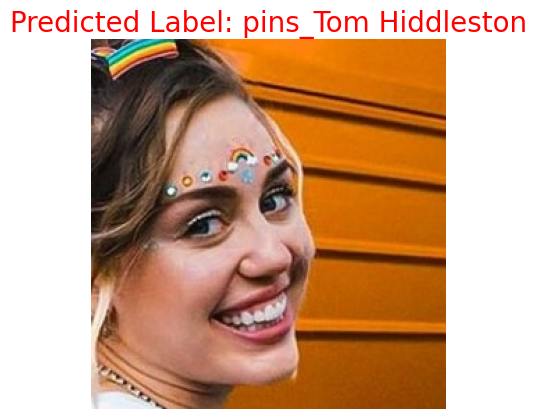

no face


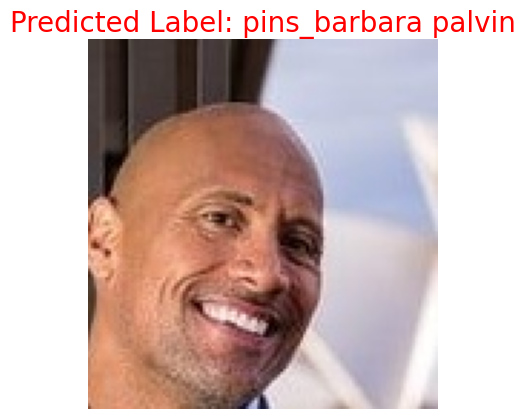

In [89]:
print("Yanlış Sınıflandırılan Resimlere Örnekler")
predict_and_visualize("105_classes_pins_dataset\pins_Miley Cyrus\Miley Cyrus0_3578.jpg", X_train, y_train,euclidean_distance) #BAD
predict_and_visualize("105_classes_pins_dataset\pins_Dwayne Johnson\Dwayne Johnson35_1663.jpg", X_train, y_train,euclidean_distance)

Doğru Sınıflandırılan Resimlere Örnekler


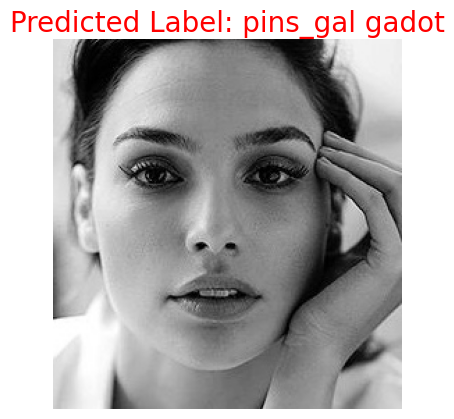

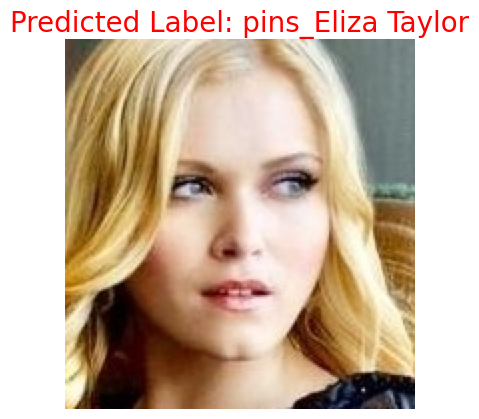

In [90]:
print("Doğru Sınıflandırılan Resimlere Örnekler")
predict_and_visualize("105_classes_pins_dataset\pins_gal gadot\gal gadot0_1658.jpg", X_train, y_train,euclidean_distance) #GOOD
predict_and_visualize("105_classes_pins_dataset\pins_Eliza Taylor\Eliza Taylor33_823.jpg", X_train, y_train,euclidean_distance)